# Imports

In [3]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as fun
from torchvision import datasets, transforms, models
from torch.utils.data import DataLoader

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Get Data

In [4]:
transform = transforms.Compose([
    transforms.Resize(32),      # resize to make sure all pictures are the same size
    # transforms.CenterCrop(28),  # get the middle 28 pixels to remove background noise and reduce computation
    transforms.ToTensor(),      # convert the images data type to tensor
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

In [5]:
train_data = datasets.CIFAR10("train_data/", train=True, download=True, transform=transform)
test_data = datasets.CIFAR10("test_data/", train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
print(train_data)

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: train_data/
    Split: Train
    StandardTransform
Transform: Compose(
               Resize(size=32, interpolation=bilinear, max_size=None, antialias=warn)
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )


In [7]:
# map classes to thier labels
class_map = {
    0: "plane",
    1: "automobile",
    2: "bird",
    3: "cat",
    4: "deer",
    5: "dog",
    6: "frog",
    7: "horse",
    8: "ship",
    9: "truck",
}

plot a few examples to see the dataset

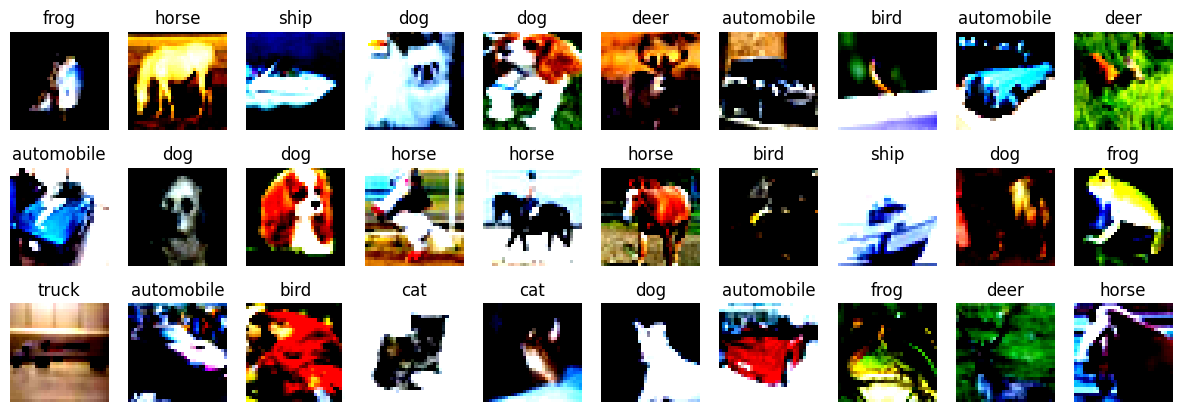

In [6]:
rows, cols = 3, 10
fig, ax = plt.subplots(rows, cols, figsize=(15,5))

for j in range(rows):
    for i in range(cols):
        ind = torch.randint(low=0, high=50000, size=(1,))
        img, label = train_data[ind]
        img = torch.stack((img[0], img[1], img[2]), dim=-1)

        ax[j][i].imshow(img)
        ax[j][i].axis("off")
        ax[j][i].set_title(class_map[label])




In [8]:
# create dataloaders
batch_size = 100

train_loader = DataLoader(dataset=train_data, batch_size=batch_size, shuffle=True,)
test_loader = DataLoader(dataset=test_data, batch_size=batch_size, shuffle=True,)


In [9]:
data, label = next(iter(train_loader))
data[0].shape

torch.Size([3, 32, 32])

# Create Neural Network

In [8]:
class NN(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(NN, self).__init__()

        hidden1 = 4096
        hidden2 = 2048
        hidden3 = 512

        self.fc1 = nn.Linear(input_shape, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc4 = nn.Linear(hidden3, output_shape)

    def forward(self, x):
        x = fun.relu(self.fc1(x))
        x = fun.relu(self.fc2(x))
        x = fun.relu(self.fc3(x))
        x = self.fc4(x)
        return x


In [12]:
class NN2(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(NN2, self).__init__()

        hidden1 = 4096 * 2
        hidden2 = 4096
        hidden3 = 2048
        hidden4 = 512

        self.fc1 = nn.Linear(input_shape, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, hidden3)
        self.fc4 = nn.Linear(hidden3, hidden4)
        self.fc5 = nn.Linear(hidden4, output_shape)

    def forward(self, x):
        x = fun.relu(self.fc1(x))
        x = fun.relu(self.fc2(x))
        x = fun.relu(self.fc3(x))
        x = fun.relu(self.fc4(x))
        x = self.fc5(x)
        return x


In [ ]:
class NN3(nn.Module):
    def __init__(self, input_shape, output_shape):
        super(NN3, self).__init__()

        hidden1 = 2048
        hidden2 = 512

        self.fc1 = nn.Linear(input_shape, hidden1)
        self.fc2 = nn.Linear(hidden1, hidden2)
        self.fc3 = nn.Linear(hidden2, output_shape)

    def forward(self, x):
        x = fun.relu(self.fc1(x))
        x = fun.relu(self.fc2(x))
        x = self.fc3(x)
        return x

set hyper parameters, weights and other variables

In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.001
epochs = 10
input_size = 32 * 32 * 3
output_size = 10
device

device(type='cuda')

In [10]:
model = NN(input_size, output_size).to(device)
# model = torch.load("model/model").to(device)
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.9)


In [23]:
def vectorize(x):
    # stack the RGB values together
    x = x.permute(0,2,3,1)


    # flatten the images
    x = x.reshape(x.shape[0], -1)

    return x

In [12]:
loss_history = []
acc_history = []

In [15]:
def train(model, epochs, optimizer, loss_fun, loss_history, accuracy_history, vector = True):
  model.train()
  model.to(device)

  for epoch in range(epochs):
    print("epoch: ", epoch+1)

    for ind, (data, targets) in enumerate(train_loader):

      data = data.to(device)
      targets = targets.to(device)

      if vector:
        data = vectorize(data)

      pred = model(data)
      loss = loss_fun(pred, targets)
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if ind % 200 == 0:
        acc = get_accuracy(model, test_loader, vector)
        print("batch: ", ind)
        print("train loss: ", loss.item())
        print("test accuracy", acc)
        accuracy_history.append(acc)
        loss_history.append(loss.item())


In [16]:
def get_accuracy(model, loader, vector=True):
    model.eval()
    model.to(device)

    total_samples = 0
    total_hits = 0

    for x, y in loader:

        # stack the RGB values together
        y = y.to(device)
        x = x.to(device)

        if vector:
          x = vectorize(x)


        with torch.no_grad():
            pred = model(x)
            pred = torch.argmax(pred, dim=1)
            total_hits += torch.sum(pred == y).item()
            total_samples += y.shape[0]

    return total_hits/total_samples



In [17]:
def get_prediction(model, loader, vector=True):
    model.eval()
    model.to(device)

    full_pred = torch.tensor([], device=device)
    full_targets = torch.tensor([], device=device)



    for x, y in loader:
        # print(x.shape)
        if vector:
          x = vectorize(x)

        x = x.to(device)
        y = y.to(device)

        with torch.no_grad():
            y_pred = model(x)
            y_pred = torch.argmax(y_pred, dim=1)

            full_pred = torch.cat((full_pred, y_pred), 0)
            full_targets = torch.cat((full_targets, y), 0)

    return full_pred.to("cpu"), full_targets.to("cpu")




In [1]:
def print_pred(model, samples, loader, vector=True):

    rows, cols = 1, samples
    fig, ax = plt.subplots(rows, cols, figsize=(15,5))

    for _ in range(samples):

        batch = next(iter(loader))
        ind = torch.randint(1, batch.size[0])
        img, label = batch[ind]

        x = img
        if vector:
            x = vectorize(img)
        
        with torch.no_grad():
            pred = model(x)
            pred = torch.argmax(pred, dim=1)


        for i in range(cols):
            ind = torch.randint(low=0, high=50000, size=(1,))
            img, label = train_data[ind]
            img = torch.stack((img[0], img[1], img[2]), dim=-1)

            ax[i].imshow(img)
            ax[i].axis("off")
            ax[i].set_title(class_map[pred])




In [16]:
get_accuracy(model, test_loader)

0.1023

In [17]:
get_accuracy(model, train_loader)

0.09944

In [19]:
for i in range(4):
    train(model, 5, optimizer, loss_fun, loss_history, acc_history)
    print(f"loop {i+1} accuracy: {get_accuracy(model, test_loader)}")
    torch.save(model, f"models/model_{i}")


epoch:  1
batch:  0
train loss:  2.3085098266601562
test accuracy 0.1022
batch:  200
train loss:  2.025026798248291
test accuracy 0.2943
batch:  400
train loss:  1.961077094078064
test accuracy 0.331
epoch:  2
batch:  0
train loss:  1.9194358587265015
test accuracy 0.3549
batch:  200
train loss:  1.7476922273635864
test accuracy 0.39
batch:  400
train loss:  1.7655483484268188
test accuracy 0.4147
epoch:  3
batch:  0
train loss:  1.6356608867645264
test accuracy 0.419
batch:  200
train loss:  1.691725254058838
test accuracy 0.4422
batch:  400
train loss:  1.6207237243652344
test accuracy 0.4486
epoch:  4
batch:  0
train loss:  1.475364327430725
test accuracy 0.4515
batch:  200
train loss:  1.5576831102371216
test accuracy 0.4658
batch:  400
train loss:  1.5211695432662964
test accuracy 0.4727
epoch:  5
batch:  0
train loss:  1.3684097528457642
test accuracy 0.4727
batch:  200
train loss:  1.4131507873535156
test accuracy 0.4838
batch:  400
train loss:  1.354727029800415
test accuracy 0

In [20]:
get_accuracy(model, test_loader)

0.5471

In [21]:
get_accuracy(model, train_loader)

0.85256

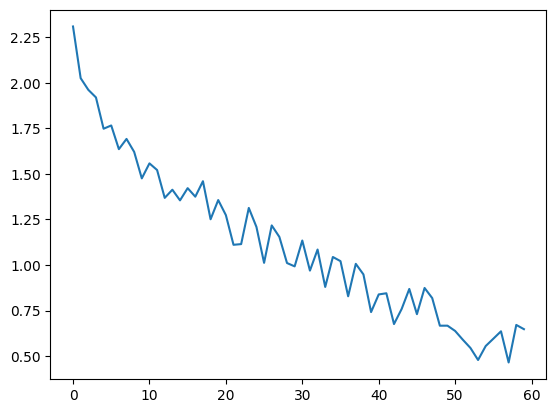

In [22]:
plt.plot(loss_history)

check the accuracy after every 5 epochs to see which model is best and to avoid overfitting

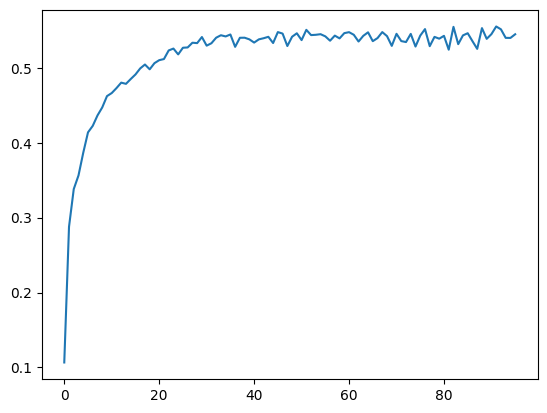

In [ ]:
plt.plot(acc_history)

In [23]:
m0 = torch.load("models/model_0")
get_accuracy(m0, test_loader)

0.4976

In [24]:
m1 = torch.load("models/model_1")
get_accuracy(m1, test_loader)

0.5296

In [25]:
m2 = torch.load("models/model_2")
get_accuracy(m2, test_loader)

0.5346

In [26]:
m3 = torch.load("models/model_3")
get_accuracy(m3, test_loader)

0.5471

the best accuracy was after 20 epochs. but it seems towards the end of the training the model was not learning well so any more epochs will probably result in overfitting.

In [38]:
pred, target = get_prediction(model, test_loader)


In [39]:
conf = confusion_matrix(pred, target)


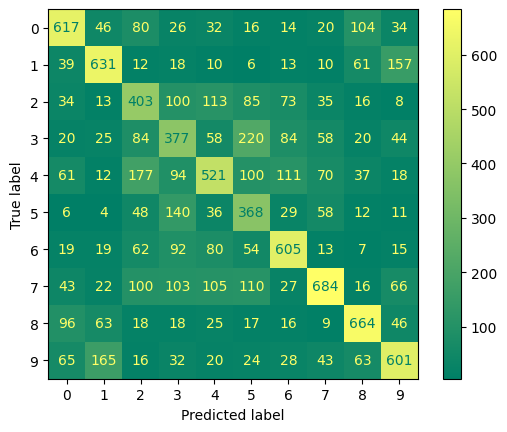

In [40]:
cm = ConfusionMatrixDisplay(conf)
cm.plot(cmap="summer")

# Train The 4 Layer Model

In [19]:
model_two = NN2(input_size, output_size).to(device)
# model = torch.load("model/model").to(device)
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_two.parameters(), lr=lr, momentum=0.9)

In [21]:
loss_history_two = []
acc_history_two = []

In [27]:
for i in range(2):
    train(model_two, 5, optimizer, loss_fun, loss_history_two, acc_history_two)
    print(f"loop {i+1} accuracy: {get_accuracy(model_two, test_loader)}")
    torch.save(model, f"models/model_{i}")

epoch:  1


batch:  0
train loss:  1.850958228111267
test accuracy 0.3381
batch:  200
train loss:  1.7901546955108643
test accuracy 0.3381
batch:  400
train loss:  1.9322041273117065
test accuracy 0.3381
epoch:  2
batch:  0
train loss:  1.7488059997558594
test accuracy 0.3381


KeyboardInterrupt: 

In [ ]:
get_accuracy(model_two, test_loader)

In [ ]:
get_accuracy(model, train_loader)

In [ ]:
plt.plot(loss_history_two)

In [ ]:
plt.plot(acc_history_two)

In [ ]:
pred, target = get_prediction(model, test_loader)
conf = confusion_matrix(pred, target)
cm = ConfusionMatrixDisplay(conf)
cm.plot(cmap="summer")

# Train The 2 Layers Model 

In [ ]:
loss_history_three= []
acc_history_three = []

In [25]:
model_three = NN2(input_size, output_size).to(device)
# model = torch.load("model/model").to(device)
loss_fun = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_three.parameters(), lr=lr, momentum=0.9)

In [ ]:
for i in range(2):
    train(model_three, 5, optimizer, loss_fun, loss_history_three, acc_history_three)
    print(f"loop {i+1} accuracy: {get_accuracy(model_three, test_loader)}")
    torch.save(model, f"models/model_{i}")

NameError: name 'loss_history_three' is not defined

In [ ]:
get_accuracy(model_three, train_loader)

In [ ]:
get_accuracy(model_three, test_loader)

In [ ]:
plt.plot(loss_history_three)

In [ ]:
plt.plot(acc_history_three)

In [ ]:
pred, target = get_prediction(model, test_loader)
conf = confusion_matrix(pred, target)
cm = ConfusionMatrixDisplay(conf)
cm.plot(cmap="summer")

# Transfer Learning

In [ ]:
vgg = models.vgg16(weights = "VGG16_Weights.DEFAULT").to(device)
resnet = models.resnet50(weights="ResNet50_Weights.DEFAULT").to(device)
googlenet = models.googlenet(weights="GoogLeNet_Weights.DEFAULT").to(device)

Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:02<00:00, 253MB/s]
Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:00<00:00, 231MB/s]
Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth
100%|██████████| 49.7M/49.7M [00:00<00:00, 159MB/s]


In [ ]:
# modify the last node to classify 10 classes
in_ft = vgg.classifier[-1].in_features
vgg.classifier[-1] = nn.Linear(in_ft, 10)


In [ ]:
vgg_optimizer = torch.optim.SGD(vgg.parameters(), lr=lr, momentum=0.9)
vgg_loss_history = []
vgg_acc_history = []

In [ ]:
train(vgg, 10, vgg_optimizer, loss_fun, vgg_loss_history, vgg_acc_history, vector=False)

epoch:  1
batch:  0
train loss:  2.7875351905822754
test accuracy 0.1033
batch:  200
train loss:  0.617611289024353
test accuracy 0.7779
batch:  400
train loss:  0.6014158725738525
test accuracy 0.8125
epoch:  2
batch:  0
train loss:  0.46590858697891235
test accuracy 0.8225
batch:  200
train loss:  0.37704840302467346
test accuracy 0.8314
batch:  400
train loss:  0.3865765631198883
test accuracy 0.8309
epoch:  3
batch:  0
train loss:  0.3886048495769501
test accuracy 0.8463
batch:  200
train loss:  0.31094539165496826
test accuracy 0.8398
batch:  400
train loss:  0.26131361722946167
test accuracy 0.851
epoch:  4
batch:  0
train loss:  0.21486233174800873
test accuracy 0.8553
batch:  200
train loss:  0.12670931220054626
test accuracy 0.8566
batch:  400
train loss:  0.2701875567436218
test accuracy 0.8624
epoch:  5
batch:  0
train loss:  0.22313851118087769
test accuracy 0.8599
batch:  200
train loss:  0.1838299185037613
test accuracy 0.8573
batch:  400
train loss:  0.1642538607120514
t

In [ ]:
get_accuracy(vgg, test_loader, vector = False)

0.8674

In [ ]:
get_accuracy(vgg, train_loader, vector = False)

0.99532

In [ ]:
torch.save(vgg, "vgg/vgg0")

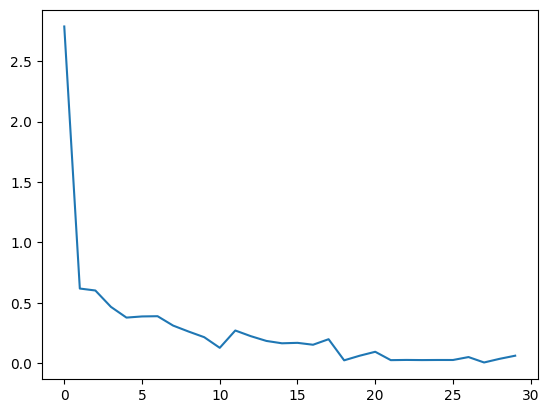

In [ ]:
plt.plot(vgg_loss_history)

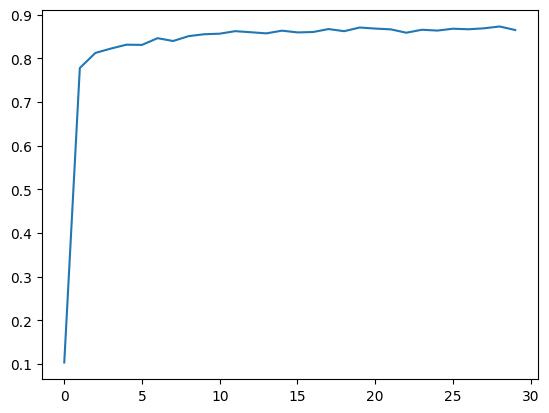

In [ ]:
plt.plot(vgg_acc_history)

In [ ]:
get_accuracy(vgg, test_loader, vector=False)

0.8674

In [ ]:
in_ft = resnet.fc.in_features
resnet.fc = nn.Linear(in_ft, 10)
loss_function = nn.CrossEntropyLoss()
resnet_optimizer = torch.optim.SGD(params=resnet.parameters(), lr=lr, momentum=0.9)
resnet_loss_history = []
resnet_acc_history = []

In [ ]:
train(resnet, 10, resnet_optimizer, loss_function, resnet_loss_history,
      resnet_acc_history, vector=False)

epoch:  1
batch:  0
train loss:  2.2978382110595703
test accuracy 0.0982
batch:  200
train loss:  0.5038493871688843
test accuracy 0.8057
batch:  400
train loss:  0.569901704788208
test accuracy 0.8286
epoch:  2
batch:  0
train loss:  0.33753636479377747
test accuracy 0.8313
batch:  200
train loss:  0.3040030002593994
test accuracy 0.848
batch:  400
train loss:  0.31375324726104736
test accuracy 0.8624
epoch:  3
batch:  0
train loss:  0.4705570936203003
test accuracy 0.849
batch:  200
train loss:  0.2696590721607208
test accuracy 0.8645
batch:  400
train loss:  0.3384179174900055
test accuracy 0.8634
epoch:  4
batch:  0
train loss:  0.1337478756904602
test accuracy 0.8683
batch:  200
train loss:  0.20729689300060272
test accuracy 0.8739
batch:  400
train loss:  0.27137207984924316
test accuracy 0.8677
epoch:  5
batch:  0
train loss:  0.10584822297096252
test accuracy 0.8689
batch:  200
train loss:  0.1991564780473709
test accuracy 0.8683
batch:  400
train loss:  0.07774347066879272
tes

In [ ]:
torch.save(resnet, "resnet/resnet0")

In [ ]:
get_accuracy(resnet, test_loader, vector=False)

0.8819

In [ ]:
get_accuracy(resnet, train_loader, vector=False)

0.99166

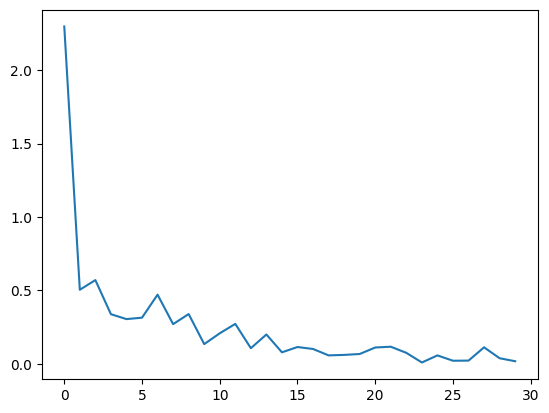

In [ ]:
plt.plot(resnet_loss_history)

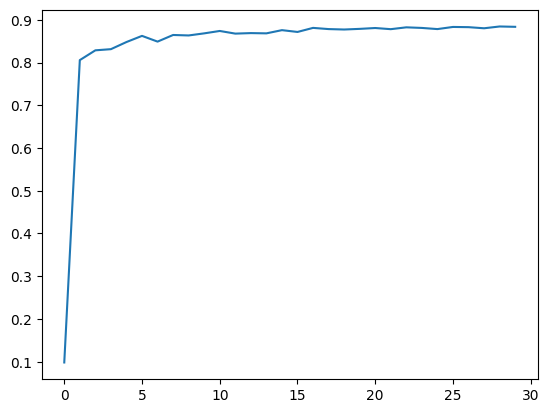

In [ ]:
plt.plot(resnet_acc_history)

In [ ]:
in_ft = googlenet.fc.in_features
googlenet.fc = nn.Linear(in_ft, 10)
loss_function = nn.CrossEntropyLoss()
googlenet_optimizer = torch.optim.SGD(params=googlenet.parameters(), lr=lr, momentum=0.9)
googlenet_loss_history = []
googlenet_acc_history = []

In [ ]:
train(googlenet, 10, googlenet_optimizer, loss_function, googlenet_loss_history,
      googlenet_acc_history, vector=False)

epoch:  1
batch:  0
train loss:  2.3691413402557373
test accuracy 0.0992
batch:  200
train loss:  1.0434354543685913
test accuracy 0.6835
batch:  400
train loss:  0.6768114566802979
test accuracy 0.7205
epoch:  2
batch:  0
train loss:  0.8220813870429993
test accuracy 0.7302
batch:  200
train loss:  0.6893158555030823
test accuracy 0.7504
batch:  400
train loss:  0.6600930690765381
test accuracy 0.7582
epoch:  3
batch:  0
train loss:  0.5525524020195007
test accuracy 0.752
batch:  200
train loss:  0.7259246110916138
test accuracy 0.7741
batch:  400
train loss:  0.5491920709609985
test accuracy 0.77
epoch:  4
batch:  0
train loss:  0.40823039412498474
test accuracy 0.7713
batch:  200
train loss:  0.49549534916877747
test accuracy 0.7869
batch:  400
train loss:  0.3785102069377899
test accuracy 0.7771
epoch:  5
batch:  0
train loss:  0.4894036054611206
test accuracy 0.7753
batch:  200
train loss:  0.5181058645248413
test accuracy 0.7882
batch:  400
train loss:  0.3490595519542694
test ac

In [ ]:
# load saved model
googlenet = torch.load("googlenet/googlenet")

In [ ]:
torch.save(googlenet, "googlenet/googlenet0")

In [ ]:
get_accuracy(googlenet, test_loader, vector=False)

0.8065

In [ ]:
get_accuracy(googlenet, train_loader, vector=False)

0.95566

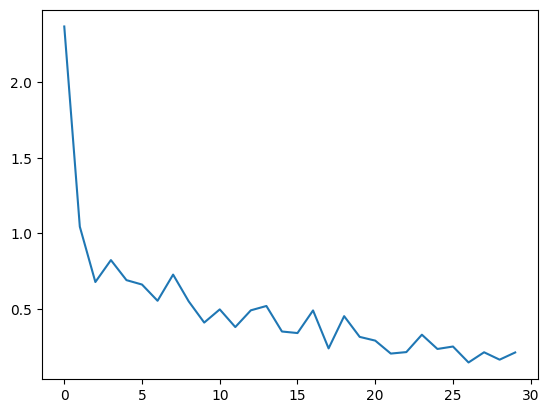

In [ ]:
plt.plot(googlenet_loss_history)

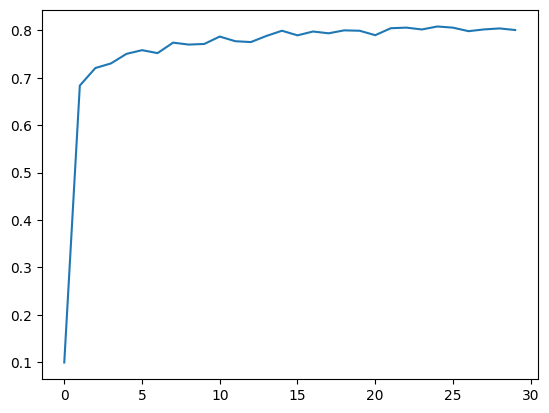

In [ ]:
plt.plot(googlenet_acc_history)

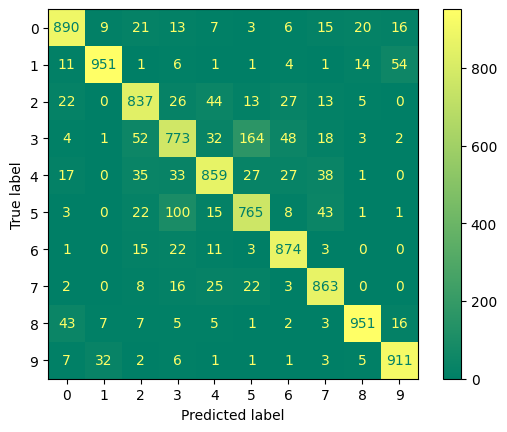

In [ ]:
vgg_pred, vgg_targets = get_prediction(vgg, test_loader, vector = False)
vgg_conf = confusion_matrix(torch.tensor(vgg_pred).cpu(), torch.tensor(vgg_targets).cpu())
cm = ConfusionMatrixDisplay(vgg_conf)
cm.plot( cmap="summer")

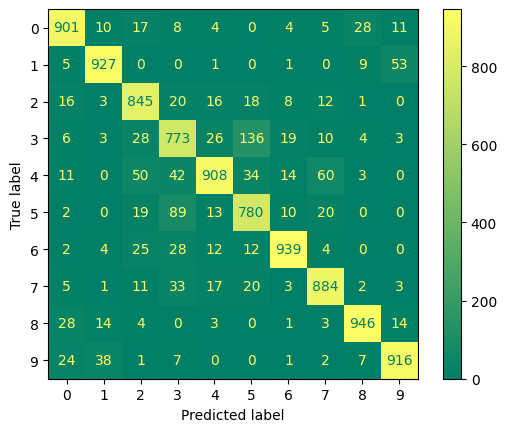

In [ ]:
resnet_pred, resnet_targets = get_prediction(resnet, test_loader, vector = False)
resnet_conf = confusion_matrix(torch.tensor(resnet_pred).cpu(), torch.tensor(resnet_targets).cpu())
cm = ConfusionMatrixDisplay(resnet_conf)
cm.plot( cmap="summer")

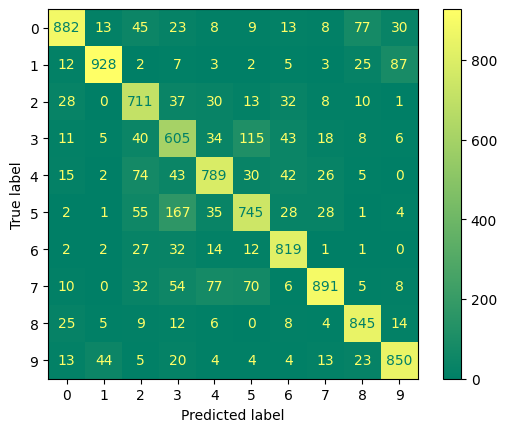

In [ ]:
googlenet_pred, googlenet_targets = get_prediction(googlenet, test_loader, vector = False)
googlenet_conf = confusion_matrix(torch.tensor(googlenet_pred).cpu(), torch.tensor(googlenet_targets).cpu())
cm = ConfusionMatrixDisplay(googlenet_conf)
cm.plot( cmap="summer")

Text(0.5, 0, 'x3')

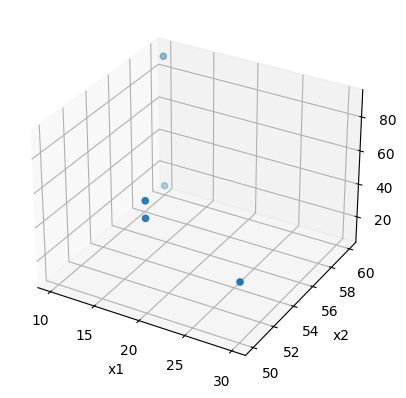

In [7]:
import matplotlib.pyplot as plt
import numpy as np

a = np.array([[10,60,90],
            [20,50,70],
            [30,50,40],
            [20,50,60],
            [10,60,10]])

fig = plt.figure()
ax = fig.add_subplot(projection='3d',)

ax.scatter(a[:,0],a[:,1],a[:,2])
ax.set_xlabel("x1")
ax.set_ylabel("x2")
ax.set_zlabel("x3")